In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
import time

warnings.filterwarnings("ignore")


In [2]:
# Load dataset

df = pd.read_csv("/content/train-5.csv")
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [4]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [5]:
# Convert date column to datetime and set as index

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


In [6]:
# Check for missing values

print("Missing Values in Dataset:")
print(df.isnull().sum())


Missing Values in Dataset:
store    0
item     0
sales    0
dtype: int64


In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
# Filter data for a specific store and item

store_id = 1
item_id = 1
df_filtered = df[(df['store'] == store_id) & (df['item'] == item_id)]


In [9]:
# Perform Augmented Dickey-Fuller test

result = adfuller(df_filtered['sales'])
print('\nADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')



ADF Statistic: -3.1576705563328042
p-value: 0.02256938062657153
Critical Values:
   1%: -3.4339840952648695
   5%: -2.8631452508003057
   10%: -2.567624583142913


<Axes: xlabel='date'>

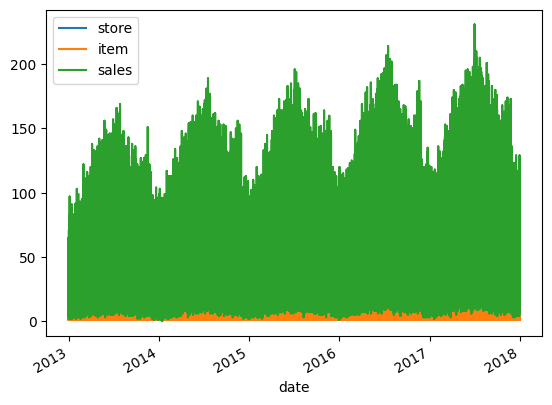

In [10]:
df.plot()

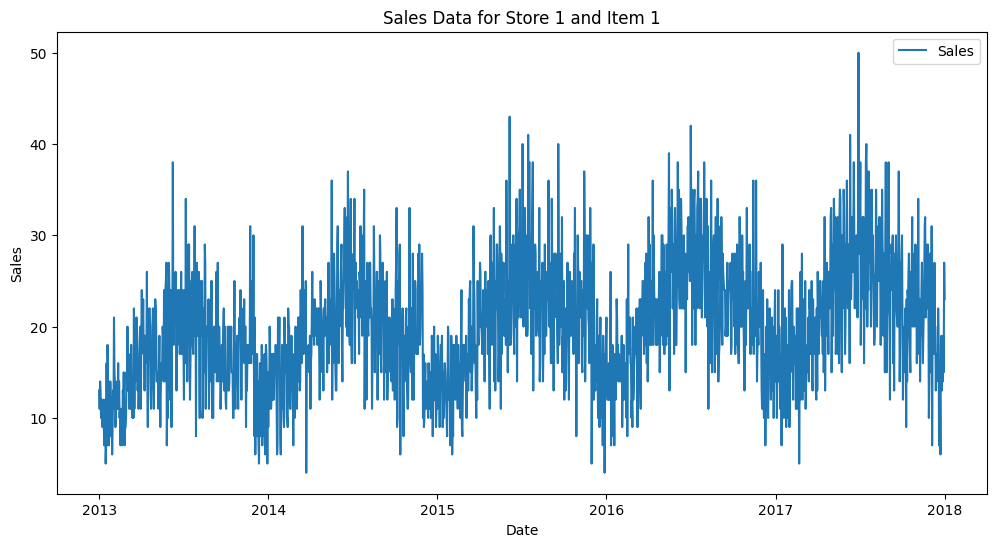

In [11]:
# Filter data for a specific store and item

plt.figure(figsize=(12, 6))
plt.plot(df_filtered['sales'], label='Sales')
plt.title(f'Sales Data for Store {store_id} and Item {item_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


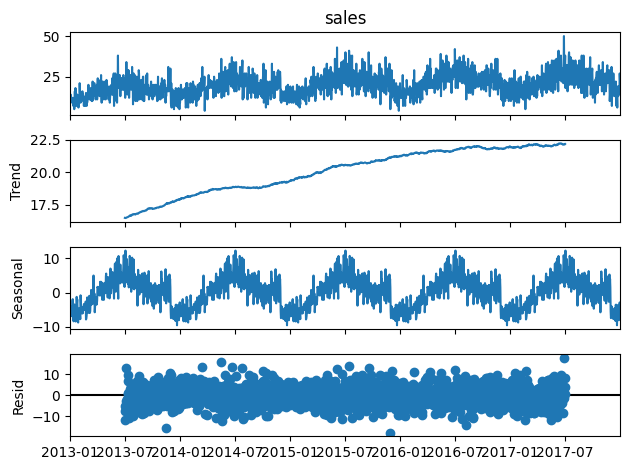

In [12]:
# Plot the data

decomposition = seasonal_decompose(df_filtered['sales'], model='additive', period=365)
fig = decomposition.plot()
plt.show()


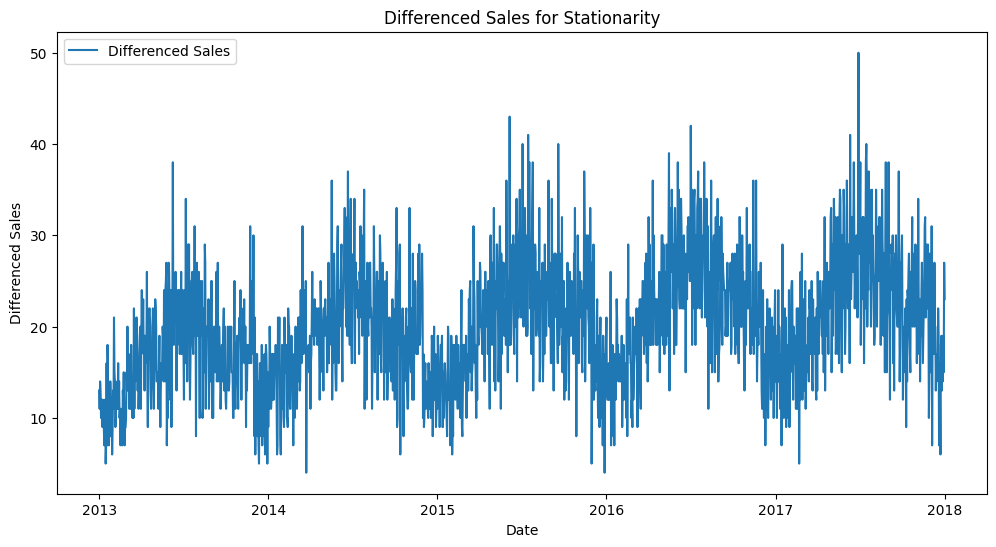


ADF Statistic (Differenced): -3.1576705563328042
p-value (Differenced): 0.02256938062657153


In [13]:
# Plot the data

if result[1] > 0.05:
    df_filtered['sales_diff'] = df_filtered['sales'].diff().dropna()
else:
    df_filtered['sales_diff'] = df_filtered['sales']

plt.figure(figsize=(12, 6))
plt.plot(df_filtered['sales_diff'], label='Differenced Sales')
plt.title('Differenced Sales for Stationarity')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.legend()
plt.show()

result_diff = adfuller(df_filtered['sales_diff'].dropna())
print('\nADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])


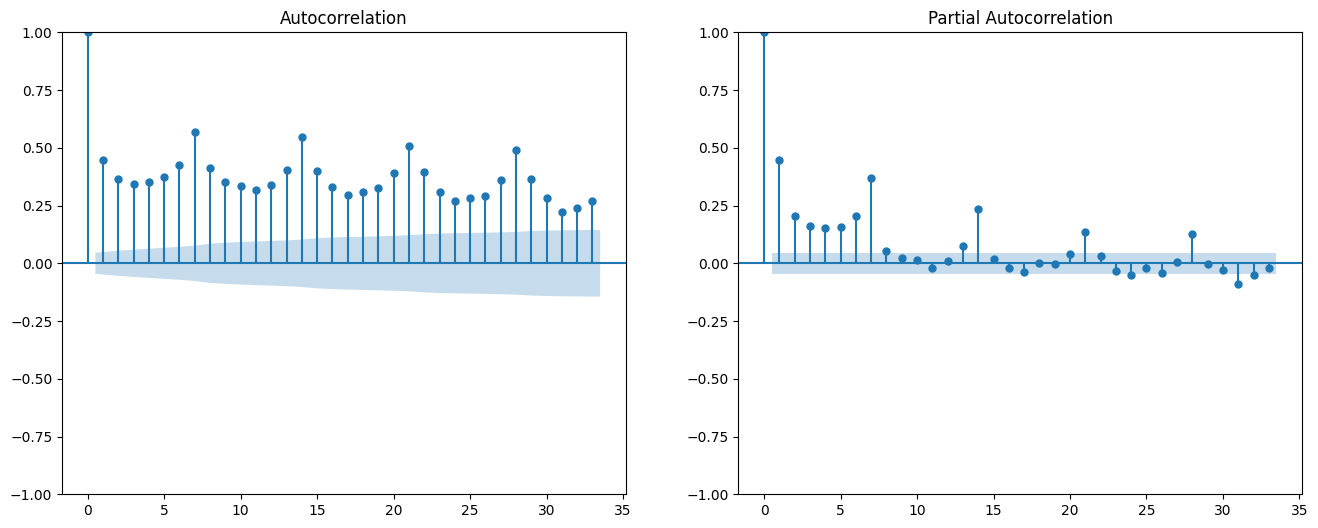

In [14]:
# acf and pacf plot

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_filtered['sales_diff'].dropna(), ax=ax[0])
plot_pacf(df_filtered['sales_diff'].dropna(), ax=ax[1])
plt.show()


In [15]:
arima_order = (1, 1, 1)


In [16]:

# Fit ARIMA model

arima_model = ARIMA(df_filtered['sales'], order=arima_order)
arima_fit = arima_model.fit()
print("\nARIMA Model Summary:")
print(arima_fit.summary())



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5666.376
Date:                Sun, 01 Sep 2024   AIC                          11338.752
Time:                        13:20:42   BIC                          11355.280
Sample:                    01-01-2013   HQIC                         11344.848
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0726      0.026      2.788      0.005       0.022       0.124
ma.L1         -0.9211      0.010    -89.047      0.000      -0.941      -0.901
sigma2        29.1043      0.8

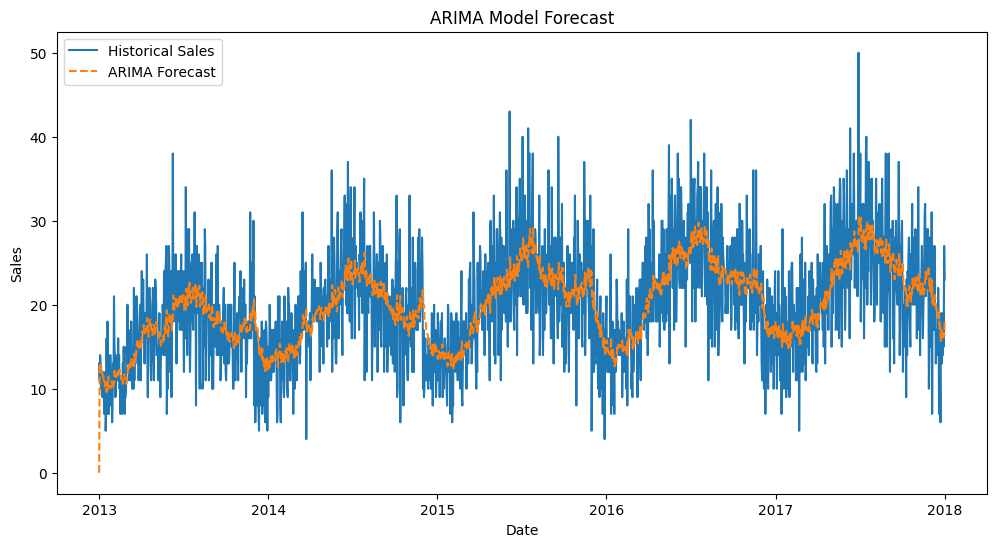

ARIMA RMSE: 5.402338988834276


In [17]:
# Plot arima forecast

arima_forecast = arima_fit.predict(start=0, end=len(df_filtered)-1, dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered['sales'], label='Historical Sales')
plt.plot(df_filtered.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

arima_rmse = np.sqrt(mean_squared_error(df_filtered['sales'], arima_forecast))
print(f'ARIMA RMSE: {arima_rmse}')


In [18]:
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Seasonal (12 months)


In [19]:
# Fit SARIMA model

sarima_model = SARIMAX(df_filtered['sales'], order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_fit.summary())



SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                 1826
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5660.572
Date:                            Sun, 01 Sep 2024   AIC                          11331.144
Time:                                    13:21:04   BIC                          11358.658
Sample:                                01-01-2013   HQIC                         11341.297
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0648      0.026      2.453      0.014       0.013       0.117
ma.L1       

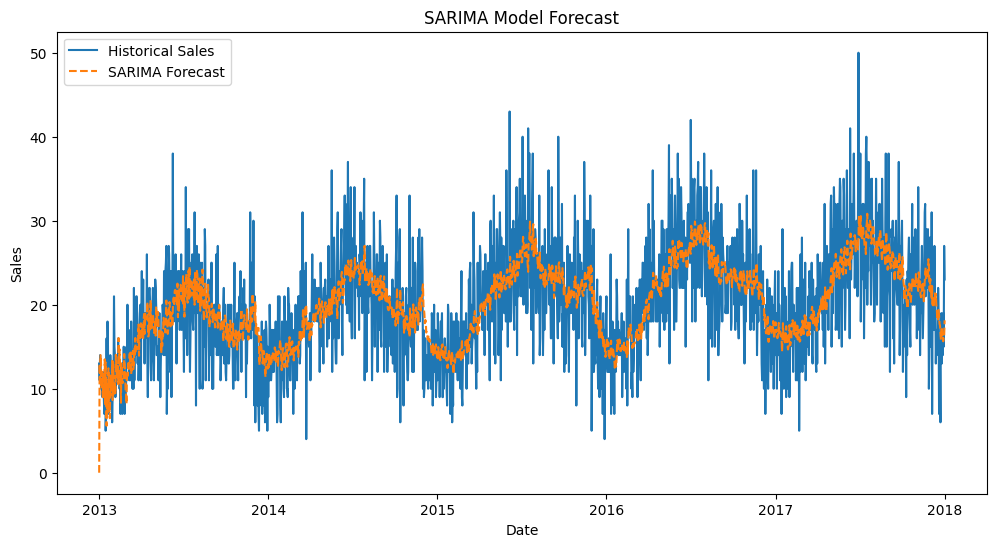

SARIMA RMSE: 5.462814877180496


In [20]:
# Plot sarima forecast

sarima_forecast = sarima_fit.predict(start=0, end=len(df_filtered)-1, dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered['sales'], label='Historical Sales')
plt.plot(df_filtered.index, sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

sarima_rmse = np.sqrt(mean_squared_error(df_filtered['sales'], sarima_forecast))
print(f'SARIMA RMSE: {sarima_rmse}')


In [21]:
# Fit ARIMA model

print(f'\nComparison of Models:')
print(f'ARIMA: RMSE = {arima_rmse}, AIC = {arima_fit.aic}')
print(f'SARIMA: RMSE = {sarima_rmse}, AIC = {sarima_fit.aic}')

if arima_fit.aic < sarima_fit.aic:
    print("SARIMA is a better model for this forecasting task.")
else:
    print("ARIMA is a better model for this forecasting task.")



Comparison of Models:
ARIMA: RMSE = 5.402338988834276, AIC = 11338.751572611573
SARIMA: RMSE = 5.462814877180496, AIC = 11331.143938403166
ARIMA is a better model for this forecasting task.
